# Age prediction


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import umap
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import nested_crossvalidation
from utilities import nested_ROC_plot

/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-usin

In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldataset.dat", sep='\t')
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [5]:
tsetse_data_copy = tsetse_data.copy()

In [6]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF = tsetse_data_copy[dList]

In [7]:
tsetse_females_thorax = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'f') & (descriptorsDF['Tissue'] == 'Thorax')]

tsetse_females_head = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'f') & (descriptorsDF['Tissue'] == 'Head')]

In [8]:
tsetse_females_thorax.groupby("Age")["ID"].count()

Age
3d    136
5w     96
7w    122
Name: ID, dtype: int64

In [9]:
tsetse_females_head.groupby("Age")["ID"].count()

Age
3d    133
5w     92
7w    120
Name: ID, dtype: int64

In [10]:
tsetse_females_thorax_copy = tsetse_females_thorax.copy()
tsetse_females_head_copy = tsetse_females_head.copy()

In [11]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF_thorax = tsetse_females_thorax[dList]
tsetse_females_thorax_copy.drop(dList, axis=1,inplace=True)


descriptorsDF_head = tsetse_females_head_copy[dList]
tsetse_females_head_copy.drop(dList, axis=1,inplace=True)

In [12]:
waveNumslist = tsetse_females_thorax_copy.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [13]:
y_labels_head = descriptorsDF_head['Age']
y_labels_thorax = descriptorsDF_thorax['Age']

## Clustering

In [14]:
# females head
reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_females_head_copy)
embedding_head = reducer.fit_transform(features_scaled)

In [15]:
# Females thorax
reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_females_thorax_copy)
embedding_thorax= reducer.fit_transform(features_scaled)

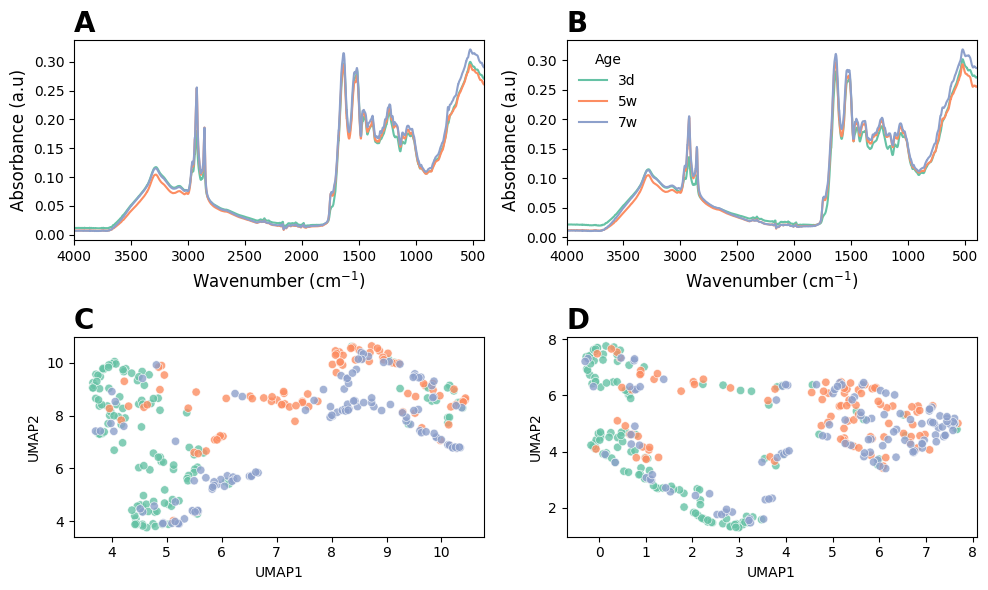

In [55]:
sn.set_palette("Set2")

fig, ((ax, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,6))

# head
sn.scatterplot(x=embedding_head[:,0], y=embedding_head[:,1], alpha=0.8, hue=descriptorsDF_head['Age'],ax=ax3, legend=False)
ax3.set_xlabel("UMAP1")
ax3.set_ylabel("UMAP2")

# thorax
sn.scatterplot(x=embedding_thorax[:,0], y=embedding_thorax[:,1], alpha=0.8, hue=descriptorsDF_thorax['Age'],legend=False,ax=ax4)
ax4.set_xlabel("UMAP1")
ax4.set_ylabel("UMAP2")
#ax3.legend( bbox_to_anchor=(0.5, 0.05, 0.3, 0.1),ncols=3,frameon=False)



# head
for i, c in zip(np.unique(y_labels_head), colors):
    sn.lineplot(x=wavenumbers, y=np.mean(tsetse_females_head_copy[y_labels_head == i], axis=0), label=i, color=c, ax=ax)
ax.get_legend().remove()
ax.set_xlim(4000,401)
ax.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)
ax.set_ylabel("Absorbance (a.u)",fontsize=12)

# thorax
for i, c in zip(np.unique(y_labels_thorax), colors):
    sn.lineplot(x=wavenumbers, y=np.mean(tsetse_females_thorax_copy[y_labels_thorax == i], axis=0), label=i, color=c,ax=ax2)
ax2.set_xlim(4000,401)
ax2.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)
ax2.set_ylabel("Absorbance (a.u)",fontsize=12)
ax2.legend(title="Age",frameon=False)


labeles = ["A", "B", "C", "D", "E", "F"]
axes = fig.get_axes()
for a, l in zip(axes, labeles):
    a.set_title(l, loc='left', fontsize=20, fontweight='bold')



plt.tight_layout()
plt.savefig("../results/plots/UMAP_Spectra_age.png", dpi=300)

## Age prediction females

In [14]:
X_thorax = tsetse_females_thorax.loc[:,"4000":"402"]
y_thorax = tsetse_females_thorax.loc[:,"Age"]

X_head = tsetse_females_head.loc[:,"4000":"402"]
y_head = tsetse_females_head.loc[:,"Age"]

In [40]:
# permutation test

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

clf = LogisticRegression(max_iter=10000, random_state=7)
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    clf, X_thorax, y_thorax, scoring="accuracy", cv=cv, n_permutations=1000)



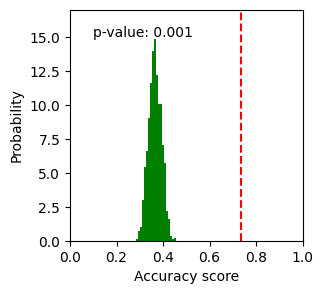

In [47]:
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(perm_scores_iris, bins=20, density=True,color='g')
ax.axvline(score_iris, ls="--", color="r")
score_label = f"p-value: {pvalue_iris:.3f}"
ax.text(0.1, 15, score_label, fontsize=10)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
ax.set_xlim(0,1)
ax.set_ylim(0,17)

plt.savefig("../results/plots/permutationtest_age_females.png", dpi=300, bbox_inches='tight')

In [15]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [16]:
shape_data = {"train_head": X_hd_train.shape,
              "train_thorax": X_th_train.shape,
              "test_head": X_hd_test.shape,
              "tsetse_thorax":X_th_test.shape}
shape_data_df = pd.DataFrame(shape_data,index=['samples','features'])
shape_data_df
shape_data_df.to_excel("../results/tables/train_test_shape_age_females.xlsx")


In [32]:
shape_data_classes = {"train_head": y_hd_train.value_counts(),
              "train_thorax": y_th_train.value_counts(),
              "test_head": y_hd_test.value_counts(),
              "tsetse_thorax":y_th_test.value_counts()}

shape_data_classes_df = pd.DataFrame(shape_data_classes)
shape_data_classes_df
shape_data_classes_df.to_excel("../results/tables/train_test_shape_age_classes_females.xlsx")

In [60]:
females_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
females_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [62]:
data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
data_plot_head = dataplotmelt(females_head_acc_baseline)

<Axes: xlabel='param_clf', ylabel='value'>

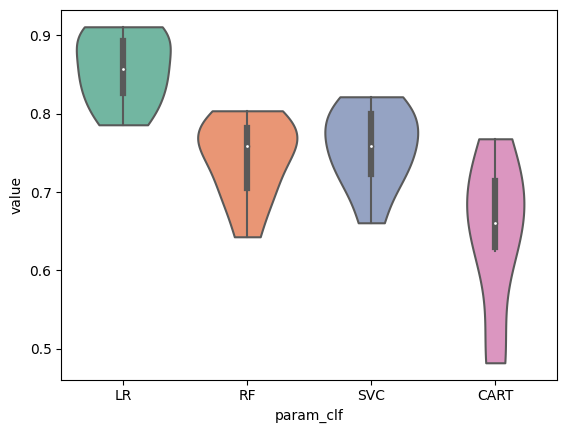

In [64]:
sn.violinplot(data=data_plot_head, x='param_clf',y='value', cut=0)

In [79]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train)

In [80]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.9130434782608695
Accuracy on test set: 0.9295774647887324


In [67]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head

,precision,recall,f1-score,support
3d,0.821429,0.958333,0.884615,24.000000
5w,1.000000,0.947368,0.972973,19.000000
7w,0.956522,0.846154,0.897959,26.000000
accuracy,0.913043,0.913043,0.913043,0.913043
macro avg,0.925983,0.917285,0.918516,69.000000
weighted avg,0.921505,0.913043,0.913974,69.000000


In [68]:
report_head.to_excel("../results/tables/accuracy_age_females_head.xlsx")

In [69]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax

,precision,recall,f1-score,support
3d,0.954545,0.954545,0.954545,22.000000
5w,0.956522,0.880000,0.916667,25.000000
7w,0.884615,0.958333,0.920000,24.000000
accuracy,0.929577,0.929577,0.929577,0.929577
macro avg,0.931894,0.930960,0.930404,71.000000
weighted avg,0.931603,0.929577,0.929531,71.000000


In [70]:
report_thorax.to_excel("../results/tables/accuracy_age_females_thorax.xlsx")

In [73]:
# roc curve for multiclass

label_binarizer = LabelBinarizer().fit(y_hd_train)
y_onehot_hd_test = label_binarizer.transform(y_hd_test)

In [98]:
label_binarizer_thorax = LabelBinarizer().fit(y_th_train)
y_onehot_th_test = label_binarizer_thorax.transform(y_th_test)

In [77]:
print(y_onehot_hd_test.shape)
print(y_hd_test.shape)

(69, 3)
(69,)


In [81]:
class_of_interest = "3d"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

0

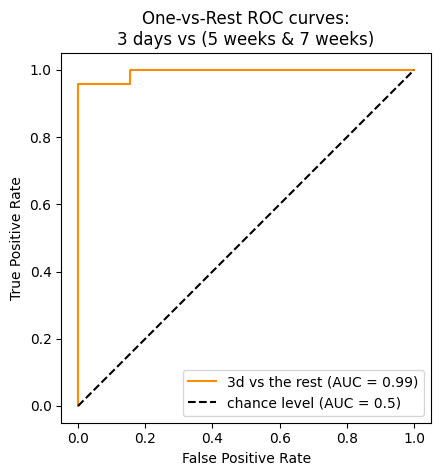

In [85]:
RocCurveDisplay.from_predictions(
    y_onehot_hd_test[:, class_id],
    y_head_prob[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n3 days vs (5 weeks & 7 weeks)")
plt.legend()
plt.show()

In [111]:
n_classes=3
target_names = ['3d','5w','7w']


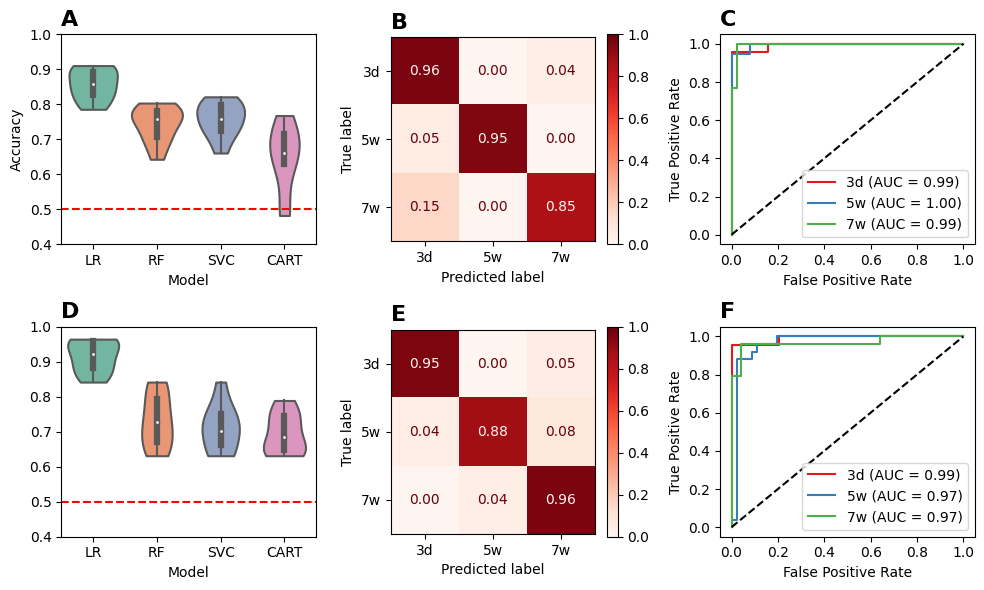

In [110]:
fig, ((ax,ax2, ax5),(ax3,ax4, ax6)) = plt.subplots(2,3,figsize=(10,6))
sn.violinplot(data=data_plot_head, x='param_clf',y='value',ax=ax, cut=0)
sn.violinplot(data=data_plot_thorax, x='param_clf', y='value', cut=0,ax=ax3)
ax.set_xlabel("Model")
ax.set_ylabel('Accuracy')
ax.set_ylim(0.4,1)
ax3.set_ylim(0.4,1)
ax.axhline(0.5, color='r',ls="--")
ax3.axhline(0.5, color='r',ls="--")
ax3.set_ylabel('')
ax3.set_xlabel("Model")


disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})


disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})

colors = sn.color_palette("Set1")
#colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_hd_test[:, class_id],
        y_head_prob[:, class_id],
        name=target_names[class_id],
        color=color,
        ax=ax5)
#ax5.get_legend().remove()

ax5.set_xlabel("False Positive Rate")
ax5.set_ylabel("True Positive Rate")

#colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_th_test[:, class_id],
        y_thorax_prob[:, class_id],
        name=target_names[class_id],
        color=color,
        ax=ax6)

ax6.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax5.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

ax6.set_xlabel("False Positive Rate")
ax6.set_ylabel("True Positive Rate")

sizeletters = 16
ax.set_title("A", loc='left', weight='bold',size=sizeletters)
ax2.set_title("B", loc='left', weight='bold', size=sizeletters)
ax3.set_title("D", loc='left', weight='bold', size=sizeletters)
ax4.set_title("E", loc='left', weight='bold', size=sizeletters)
ax5.set_title("C", loc='left', weight='bold', size=sizeletters)
ax6.set_title("F", loc='left', weight='bold', size=sizeletters)

plt.tight_layout()

plt.savefig("../results/plots/age_prediction.png", dpi=300)